### Imports

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from torch.nn import functional as F
from torch import nn

import pytorch_lightning as pl

root = 'C:\\Users\\appel\\Documents\\Unity\\Embeddings\\Assets\\Python'
os.chdir(root)

In [3]:
def convert_to_pil_image(batch):
    for cam in batch.unsqueeze(0):
        row = make_grid(cam, nrow=cam.shape[0], padding=10, normalize=True, pad_value=1)
        combined_grid = torch.cat((combined_grid, row), dim=1) if 'combined_grid' in locals() else row
    return to_pil_image(combined_grid)

# Unity Dataset

In [4]:
from unity import UnityDataset, UnityDataModule

In [7]:
unitydataset = UnityDataset(epoch_length=100, port=8092)
unitydatamodule = UnityDataModule(unitydataset, batch_size=5, num_workers=0, shuffle=True)

torch.Size([5, 1, 128, 128])
tensor([[-1.2768,  0.0000, 10.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,
          0.0000],
        [ 1.0466,  0.0000, 10.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,
          0.0000],
        [-2.5658,  0.0000, 10.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.5478,  0.0000, 10.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,
          0.0000],
        [ 2.0561,  0.0000, 10.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,
          0.0000]])


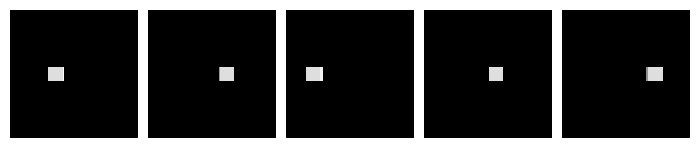

In [8]:
for batch in unitydatamodule.train_dataloader():
    pil_image = convert_to_pil_image(batch['cameras'])
    
    print(batch['cameras'].shape)
    print(batch['json'])

    break

pil_image

# Cube position estimator

In [43]:
import wandb
from pytorch_lightning.loggers import WandbLogger

In [56]:
class CubePositionEstimator(pl.LightningModule):
    def __init__(self):
        super(CubePositionEstimator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*32*32, 512)  # this would depend on the image size
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(1)

    def training_step(self, batch, batch_idx):
        images = batch['cameras']
        x_coords = batch['json'][:, 0] # assuming x-coordinate is at index 0
        outputs = self(images)
        loss = F.mse_loss(outputs, x_coords)
        
        if batch_idx % 10 == 0:  # adjust as needed
            # select some sample images from the batch
            sample_imgs = images[:5]
            # log the images
            self.logger.experiment.log({"images": [wandb.Image(img) for img in sample_imgs]})
            # log the target and predicted coordinates
            self.logger.experiment.log({"target_coords": x_coords[:5],
                                        "predicted_coords": outputs[:5]})
        
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        images = batch['cameras']
        x_coords = batch['json'][:, 0]
        outputs = self(images)
        loss = F.mse_loss(outputs, x_coords)
        self.log('val_loss', loss)
        return {'loss': loss}
    
    def test_step(self, batch, batch_idx):
        images = batch['cameras']
        x_coords = batch['json'][:, 0]
        outputs = self(images)
        loss = F.mse_loss(outputs, x_coords)
        self.log('test_loss', loss)
        return {'loss': loss, 'output': outputs, 'image': images}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
model = CubePositionEstimator()

In [57]:
wandb_logger = WandbLogger(project="cubes", name="cubes1")
trainer = pl.Trainer(max_epochs=1, log_every_n_steps=1, logger=wandb_logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [58]:
unitydataset = UnityDataset(epoch_length=4096, port=8092)
unitydatamodule = UnityDataModule(unitydataset, batch_size=32, num_workers=0, shuffle=True)

In [59]:
trainer.fit(model, unitydatamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 320   
1 | conv2 | Conv2d | 18.5 K
2 | fc1   | Linear | 33.6 M
3 | fc2   | Linear | 513   
---------------------------------
33.6 M    Trainable params
0         Non-trainable params
33.6 M    Total params
134.297   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0:  24%|██▍       | 31/128 [00:21<01:08,  1.41it/s, v_num=lvx6]

KeyError: 'json'

In [32]:
test_results = trainer.test(model, unitydatamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\appel\anaconda3\envs\image_synthesis_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 128/128 [01:23<00:00,  1.54it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     5.335709571838379     │
└───────────────────────────┴───────────────────────────┘

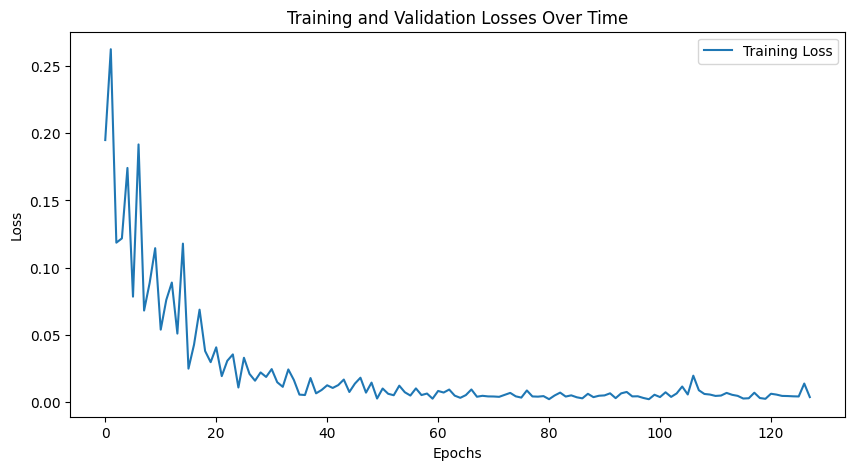

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from csv
df = pd.read_csv(r'C:\Users\appel\Documents\Unity\Embeddings\Assets\Python\lightning_logs\version_19\metrics.csv')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(df['train_loss'], label='Training Loss')

# If validation loss is present in the csv, plot that as well
if 'val_loss' in df.columns:
    plt.plot(df['val_loss'], label='Validation Loss')

plt.title('Training and Validation Losses Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
